# Causal Modeling DML - Modeling Selection & Validation - CR

Author: Lujun LI

Based on the data we have, we primarily use DML as our CATE estimation framework. Our goal is to find the best model for different scenarios.

The basic framework we use is from EconML, which includes:
- Linear DML
- Causal Forest DML

The model functions we use are mainly chosen from:
- Lasso
- Random Forest Regressor
- XGBoost Regressor

For validation, we mainly use R score, MAPE, and the score function to evaluate model performance. We divide the interventional data into 60% training data and 40% validation data.

Grid Search will be used for hyperparameter tuning to find the best hyperparameters for each model. The `model_y`, `model_t`, and `model_final` may use different fitting models.

The estimation of marginal CATE will be obtained at different temperatures, and then the shape values will be used for further explanation.

In [2]:
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

networkx backend defined more than once: nx-loopback


Let's import a test set and try to run normally every model we want to check

In [14]:
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/causal_disvoery_improved"  # Define the folder path
output_photo_name = f"MT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["Temperature"] = df["Temperature"].astype(float).round(1)

one_hot_model = pd.get_dummies(df["model_name"], dtype=int)
model_columns = one_hot_model.columns.tolist()
df = pd.concat([df, one_hot_model], axis=1)

model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}

marker_map = {
    "Llama-2-7b-chat-hf": ".",
    "Llama-2-13b-chat-hf": "*",
    "Llama-2-70b-chat-hf": "o",
    "Meta-Llama-3-8B-Instruct": "+",
    "Meta-Llama-3-70B-Instruct": "^",
    "Mistral-7B-Instruct-v0.2": "<",
    "Mixtral-8x7B-Instruct-v0.1": ">",
}

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
}

folder_path = "Paper Experiment Results/New_filtered/mt"
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)
df["Temperature"] = df["Temperature"].round(1)
df["model_encoded"] = df["model_name"].map(model_map)


def string_to_boolean(s):
    s_stripped = s.strip("[]")
    return s_stripped.lower() == "true"


df["eval"] = df["eval"].apply(lambda x: string_to_boolean(x))
df["eval"] = df["eval"].apply(lambda x: 1 if x else 0)
node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "eval",
    "time_per_char",
] + model_columns

causal_dataset_df = df[node_labels]

grouped = causal_dataset_df.groupby(["model_encoded", "Temperature"])
train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    split_index = int(len(group) * 0.6)
    train = group.iloc[:split_index]
    validation = group.iloc[split_index:]
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

# Temperature Scaling
start = 0.1
stop = 2.1
step = 0.3
control_values = np.arange(start, stop, step)

At this time we got trainset set and validation set and let's check if that's correct.

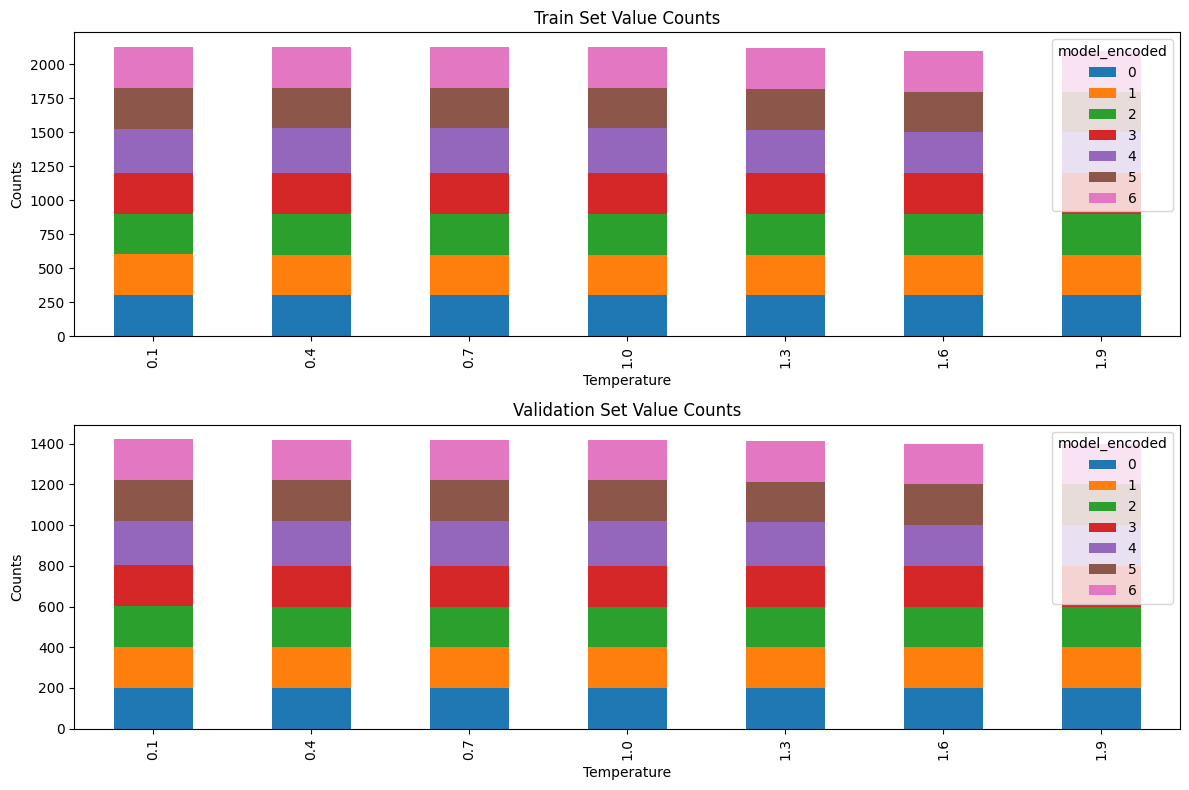

In [15]:
train_counts = (
    train_set[["Temperature", "model_encoded"]].value_counts().unstack(fill_value=0)
)
validation_counts = (
    validation_set[["Temperature", "model_encoded"]]
    .value_counts()
    .unstack(fill_value=0)
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

train_counts.plot(kind="bar", stacked=True, ax=axes[0], title="Train Set Value Counts")
validation_counts.plot(
    kind="bar", stacked=True, ax=axes[1], title="Validation Set Value Counts"
)
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

cols = [
    "initial_prompt_length",
] + model_columns
T_train = train_set["Temperature"].values
X_train = train_set[cols].values
Y_train = train_set["eval"].values
T_val = validation_set["Temperature"].values
X_val = validation_set[cols].values
Y_val = validation_set["eval"].values
T = causal_dataset_df["Temperature"].values
X = causal_dataset_df[cols].values
Y = causal_dataset_df["eval"].values

Let's start with the first model

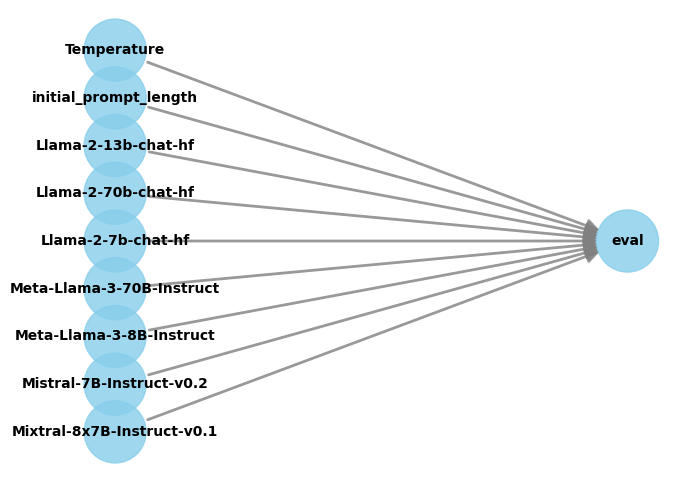

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                
──────────────(E[eval])
d[Temperature]         
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→eval then P(eval|Temperature,,U) = P(eval|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/lujun/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.ba

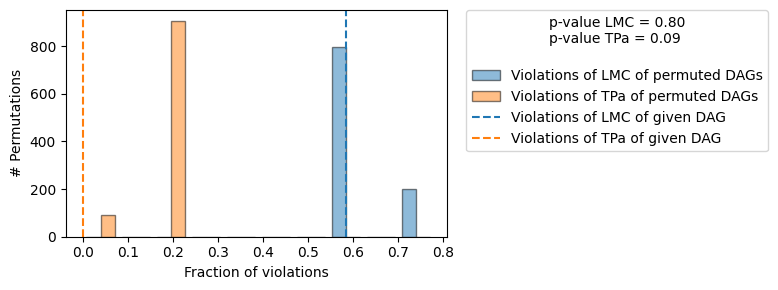

In [16]:
from dowhy import CausalModel
from dowhy.gcm.falsify import falsify_graph

model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["eval"],
    effect_modifiers=cols,
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

result = falsify_graph(
    causal_graph=model._graph._graph,
    data=causal_dataset_df,
    plot_histogram=True,
    n_permutations=1000,
    suggestions=True,
)

dict_summary = result.__dict__["summary"]

keys = list(dict_summary.keys())
if len(keys) >= 2:
    TPA = keys[0]
    LMC = keys[1]

# Graph Refutation 1
p_value_TPA = [
    value for key, value in dict_summary[TPA].items() if "P_VALUE" in key.name
][0]
# Graph Refutation 2
p_value_LMC = [
    value for key, value in dict_summary[LMC].items() if "P_VALUE" in key.name
][0]

In [21]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.linear_model import WeightedLasso
from sklearn.base import clone
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML

model_y_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # use parallel
)

model_t_list = GridSearchCVList(
    [
        Lasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
        GradientBoostingRegressor(random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "min_samples_leaf": [10, 30, 50],
        },
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)


model_final = GridSearchCVList(
    [
        WeightedLasso(max_iter=10000),
        RandomForestRegressor(n_estimators=100, random_state=123),
    ],
    param_grid_list=[
        {"alpha": [0.001, 0.01, 0.1, 1, 10]},
        {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        {},
    ],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

featurizer = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
model_y_best = model_y_list.fit(X_train, Y_train.ravel()).best_estimator_
model_t_best = model_t_list.fit(X_train, Y_train.ravel()).best_estimator_

dml_estimate_linear = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            "treatment_featurizer": featurizer,
            "cv": 5,
        }
    },
    fit_estimator=True,
)

dml_estimate_CausalForest = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            "treatment_featurizer": featurizer,
            "cv": 5,
            "n_estimators": 2000,
            "random_state": 123,
        }
    },
    fit_estimator=True,
)

dml_estimate_NonParamDML = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.NonParamDML",
    method_params={
        "init_params": {
            "model_y": "auto",
            "model_t": "auto",
            # "treatment_featurizer": featurizer,
            "model_final": model_final,
            "cv": 5,
        }
    },
    fit_estimator=True,
)

Co-variance matrix is underdetermined. Inference will be invalid!
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [22]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


def calculate_true_effect(validation_set, control_temp, target_temp):
    control_data = validation_set[validation_set["Temperature"] == control_temp][
        "eval"
    ].reset_index(drop=True)
    target_data = validation_set[validation_set["Temperature"] == target_temp][
        "eval"
    ].reset_index(drop=True)

    min_length = min(len(control_data), len(target_data))
    control_data = control_data[:min_length]
    target_data = target_data[:min_length]

    if not control_data.empty and not target_data.empty:
        true_effect = target_data - control_data
        ate = true_effect.mean()  # Calculate the average treatment effect (ATE)
    else:
        ate = None

    return ate, min_length


def calculate_ates(validation_set, dml_estimate, calculate_true_effect, is_plot=False):
    """
    Calculate true and predicted Average Treatment Effects (ATEs) for temperature ranges.

    Args:
    validation_set (DataFrame): The validation dataset containing Temperature column.
    dml_estimate (object): The Double Machine Learning estimator object.
    calculate_true_effect (function): Function to calculate the true effect.

    Returns:
    tuple: A tuple containing two lists: true_ates and predict_ates.
    """
    true_ates = []
    predict_ates = []
    temperatures = sorted(validation_set["Temperature"].unique())
    estimator_econml = dml_estimate.estimator.estimator

    for i in range(len(temperatures) - 1):
        control_temp = temperatures[i]
        target_temp = temperatures[i + 1]
        true_ate, min_length = calculate_true_effect(
            validation_set, control_temp, target_temp
        )
        true_ates.append(true_ate)
        predict_ate = estimator_econml.ate(
            X=validation_set[validation_set["Temperature"] == control_temp][cols],
            T0=control_temp,
            T1=target_temp,
        )
        predict_ates.append(predict_ate)

    if is_plot:
        # To see the results of the predictied ATE and true ATE in the validation sets.
        plt.figure(figsize=(10, 6))
        plt.plot(temperatures[:-1], true_ates, label="True ATE", marker="o")
        plt.plot(temperatures[:-1], predict_ates, label="Predicted ATE", marker="x")
        plt.xlabel("Temperature")
        plt.ylabel("ATE")
        plt.title("True ATE vs Predicted ATE by Temperature")
        plt.legend()
        plt.grid(True)
        plt.show()
    return true_ates, predict_ates


true_ates_linear, predict_ates_linear = calculate_ates(
    validation_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest, predict_ates_CausalForest = calculate_ates(
    validation_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)
true_ates_NonParamDML, predict_ates_NonParamDML = calculate_ates(
    validation_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

# Estimation results on the validation sets.
mse_results = {}

mse_results["linear"] = mean_squared_error(true_ates_linear, predict_ates_linear)
mse_results["CausalForest"] = mean_squared_error(
    true_ates_CausalForest, predict_ates_CausalForest
)
mse_results["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML, predict_ates_NonParamDML
)

In [25]:
# Calculate MSE for the best model
true_ates_linear_val, predict_ates_linear_val = calculate_ates(
    validation_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest_val, predict_ates_CausalForest_val = calculate_ates(
    validation_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)

true_ates_NonParamDML_val, predict_ates_NonParamDML_val = calculate_ates(
    validation_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

true_ates_linear_train, predict_ates_linear_train = calculate_ates(
    train_set, dml_estimate_linear, calculate_true_effect, is_plot=False
)

true_ates_CausalForest_train, predict_ates_CausalForest_train = calculate_ates(
    train_set, dml_estimate_CausalForest, calculate_true_effect, is_plot=False
)

true_ates_NonParamDML_train, predict_ates_NonParamDML_train = calculate_ates(
    train_set, dml_estimate_NonParamDML, calculate_true_effect, is_plot=False
)

mse_results_val = {}

mse_results_val["linear"] = mean_squared_error(
    true_ates_linear_val, predict_ates_linear_val
)
mse_results_val["CausalForest"] = mean_squared_error(
    true_ates_CausalForest_val, predict_ates_CausalForest_val
)
mse_results_val["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML_val, predict_ates_NonParamDML_val
)

mse_results_train = {}

mse_results_train["linear"] = mean_squared_error(
    true_ates_linear_train, predict_ates_linear_train
)
mse_results_train["CausalForest"] = mean_squared_error(
    true_ates_CausalForest_train, predict_ates_CausalForest_train
)
mse_results_train["NonParamDML"] = mean_squared_error(
    true_ates_NonParamDML_train, predict_ates_NonParamDML_train
)
print(mse_results_train)
print(mse_results_val)
# Not overfitting

{'linear': 0.0001205351607188208, 'CausalForest': 0.00012072828782092703, 'NonParamDML': 0.00016462869694343558}
{'linear': 0.0001247305029397916, 'CausalForest': 0.00013694419293009977, 'NonParamDML': 0.00019034177836306257}


Get parameters of each model

In [26]:
# use the best model for the final estimation
# calculate_ates(
#     causal_dataset_df[causal_dataset_df["model_encoded"] == 1],
#     dml_estimate_CausalForest,
#     calculate_true_effect,
#     is_plot=False,
# )

model_encodes = sorted(causal_dataset_df["model_encoded"].unique())  # Get unique values

ates_models = {}
model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}


def find_model_name(model_map, model_encode):
    for key, value in model_map.items():
        if value == model_encode:
            return key
    return None  # Return None if model_name is not found in model_map


for model_encode in model_encodes:
    _, predict_ates = calculate_ates(
        causal_dataset_df[causal_dataset_df["model_encoded"] == model_encode],
        dml_estimate_CausalForest,
        calculate_true_effect,
        is_plot=False,
    )
    model_name = find_model_name(model_map, model_encode)
    ates_models[model_name] = predict_ates

_, predict_avg_ates = calculate_ates(
    causal_dataset_df,
    dml_estimate_CausalForest,
    calculate_true_effect,
    is_plot=False,
)

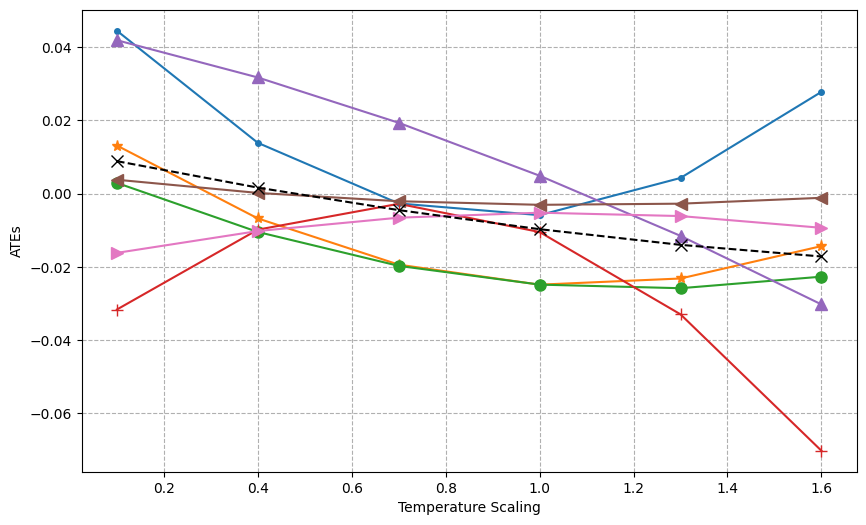

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
temperatures = sorted(causal_dataset_df["Temperature"].unique())
for model_name, predict_ates in ates_models.items():
    plt.plot(
        temperatures[:-1],
        predict_ates,
        label=model_name,
        marker=marker_map[model_name],
        color=color_map[model_name],
        markersize=8,
    )

plt.plot(
    temperatures[:-1],
    predict_avg_ates,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)
plt.xlabel("Temperature Scaling")  # Adjust x-axis label as needed
plt.ylabel("ATEs")  # Adjust y-axis label as needed
plt.grid(
    linestyle="--",
)
# plt.title("Average Treatment Effect over Time by Model")  # Adjust title as needed
# plt.legend()  # Show legend with model labels
plt.savefig("CR.svg", format="svg", bbox_inches="tight")
plt.grid(True)  # Show grid
plt.show()

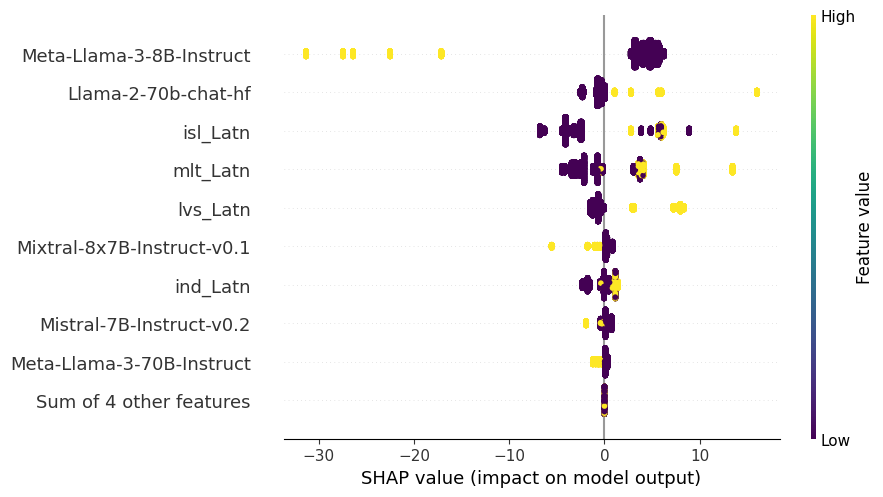

In [ ]:
import matplotlib.pyplot as pl
import shap

pl.figure(figsize=(30, 10))
shap.plots.beeswarm(
    shap_values["spbleu"]["Temperature"],
    color=pl.get_cmap("viridis"),
    order=shap_values["spbleu"]["Temperature"].abs.max(0),
    show=False,
)
pl.savefig("beeswarm_plot.pdf", format="pdf", dpi=700)

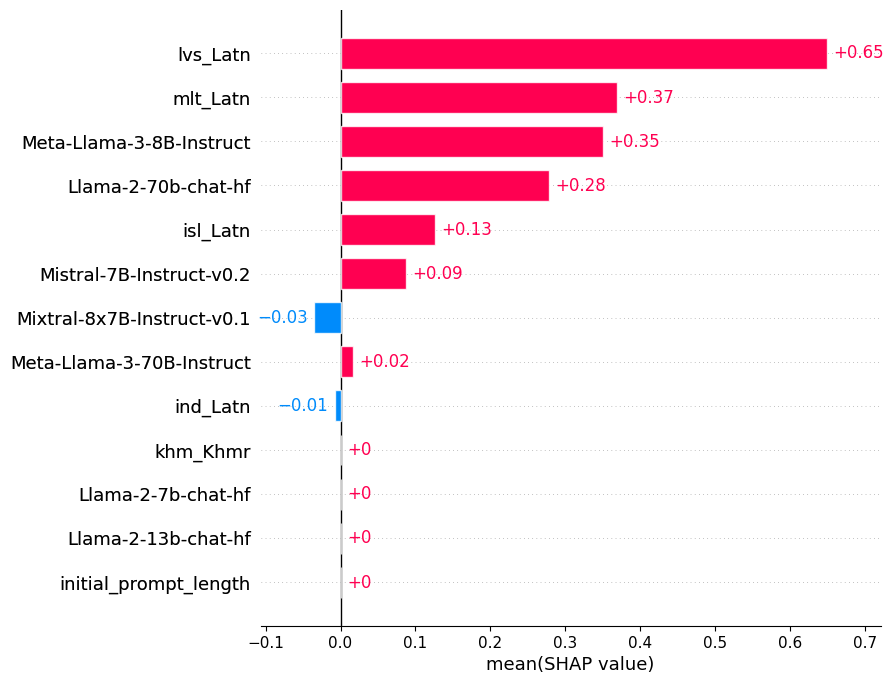

In [44]:
# shap.plots.beeswarm(shap_values["spbleu"]["Temperature"], color="shap_red")

shap.plots.bar(
    shap_values["spbleu"]["Temperature"].mean(0),
    max_display=100,
)